In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [14]:
MODEL_PATH = './models/'
DATA_PATH = './data/2017'
# DATA_PATH = './data/2017_numpy'
FRAME_PATH = DATA_PATH+'/frames/'
MASK_PATH = DATA_PATH+'/masks/'

## Loading 2017 image/label data

In [6]:
HEIGHT = 1400
WIDTH = 1400

# def load_data():
    
X = []
y = []

for file in sorted(os.listdir(FRAME_PATH)):   
    if file.startswith('R'):
        filename = file.split('.')[0]

        frame = np.load(os.path.join(FRAME_PATH, filename + '.npy'))
        mask = np.load(os.path.join(MASK_PATH, filename + '_labels.npy'))
        X.append(frame[:HEIGHT, :WIDTH, :])
        y.append(mask[:HEIGHT, :WIDTH])

X = np.array(X)
y = np.array(y)

# return X, y

## Data pre-processing functions

In [8]:
def reshape_data(X, y):
    X_reshaped = X.reshape(-1, X.shape[-1])
    y_reshaped = y.reshape(-1)

    return X_reshaped, y_reshaped

In [9]:
def shuffle_data(X, y):

    data = np.c_[X, y]
    np.random.shuffle(data)

    X_shuffled = data[:, :-1]
    y_shuffled = data[:, -1]

    return X_shuffled, y_shuffled

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# train/test
def normalize(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

def standardize(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

## Intersection-Over-Union metric

In [124]:
def iou(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    iou = tp / (tp + fn + fp)
    return iou

## Function to save model parameters

In [18]:
import pickle

def save_model(model, filename):
# Save to file in the current working directory
    with open(os.path.join(MODEL_PATH, filename+'.pkl'), 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    # Load from file
    with open(os.path.join(MODEL_PATH, filename), 'rb') as file:
        pickle_model = pickle.load(file)
        
    return pickle_model

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_val, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

## Training data
X_train, y_train = reshape_data(X_train, y_train)
X_train, y_train = shuffle_data(X_train, y_train)

X_train_standardized = standardize(X_train)

## Validation data
X_val, y_val = reshape_data(X_val, y_val)
X_val, y_val = shuffle_data(X_val, y_val)

X_val_standardized = standardize(X_val)

## Logistic regression training on 2017 data

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Training Logistic Regression
logmodel = LogisticRegression(solver='lbfgs', max_iter=300)
logmodel.fit(X_train_standardized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
## saving model to disk
save_model(logmodel, 'log_model_2017_07_19')

## Logistic regression results on validation data

In [23]:
# Testing 
y_pred = logmodel.predict(X_val_standardized)

print('Accuracy: %.2f' % accuracy_score(y_val, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_val, y_pred))
print('Classification report:\n', classification_report(y_val, y_pred))

Accuracy: 0.92
Confusion Matrix: 
 [[8278645  502616]
 [ 406928 2571811]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.95   8781261
         1.0       0.84      0.86      0.85   2978739

    accuracy                           0.92  11760000
   macro avg       0.89      0.90      0.90  11760000
weighted avg       0.92      0.92      0.92  11760000



## Testing on 2018 Data

In [35]:
DATA_2018_PATH = './data/2018/'
FRAME_2018_PATH = DATA_2018_PATH+'/frames/'
MASK_2018_PATH = DATA_2018_PATH+'/masks/'

In [40]:
date_2108_files = {}

for file in sorted(os.listdir(FRAME_2018_PATH)):   
    if file.startswith('R'):
        filename = file.split('.')[0]
        region = filename.split('_')[0]
        date = filename.split('_', maxsplit=1)[1]

        if date in date_2108_files:
            date_2108_files[date].append(region)
        else:
            date_2108_files[date] = [region]

In [45]:
HEIGHT = 1400
WIDTH = 1400

def fetch_data_by_date(day, df):
    X = []
    y = []
    
    data = df[day]
    
    for region in data:
        filename = region + '_' + day

        frame = np.load(os.path.join(FRAME_2018_PATH, filename + '.npy'))
        mask = np.load(os.path.join(MASK_2018_PATH, region + '_labels.npy'))

        X.append(frame[:HEIGHT, :WIDTH, :])
        y.append(mask[:HEIGHT, :WIDTH])
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [122]:
day = '2018_07_19'
X_2018, y_2018 = fetch_data_by_date(day, date_2108_files)

In [123]:
X_2018_reshaped, y_2018_reshaped = reshape_data(X_2018, y_2018)
X_2018_std = standardize(X_2018_reshaped)

y_2018_pred = logmodel.predict(X_2018_std)

In [131]:
cm = confusion_matrix(y_2018_reshaped, y_2018_pred)

print('Accuracy: %.2f' % accuracy_score(y_2018_reshaped, y_2018_pred))
print('Intersection Over Union: %.2f' % iou(cm))
print('Confusion Matrix: \n', cm)
print('Classification report:\n', classification_report(y_2018_reshaped, y_2018_pred))

Accuracy: 0.90
Intersection Over Union: 0.71
Confusion Matrix: 
 [[25933983  2070923]
 [ 1817760  9377334]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93  28004906
           1       0.82      0.84      0.83  11195094

    accuracy                           0.90  39200000
   macro avg       0.88      0.88      0.88  39200000
weighted avg       0.90      0.90      0.90  39200000



## Predicted 2018 sample

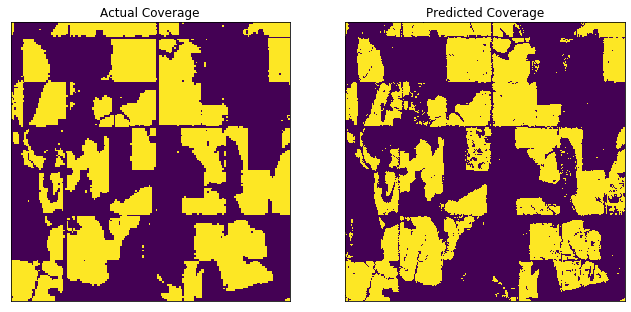

In [127]:
f = plt.figure(figsize=(11,6))

plt.subplot(121)
plt.title('Actual Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(y_2018.reshape(20,1400,1400)[1][:500,:500])

plt.subplot(122)
plt.title('Predicted Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(y_2018_pred.reshape(20,1400,1400)[1][:500,:500])

In [133]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


cm = confusion_matrix(y_2018_pred.flatten(), y_2018.flatten())

print('Accuracy: %.2f' % accuracy_score(y_pred.flatten(), y_test.flatten()))
print('Intersection Over Union: %.2f' % iou(cm))
print('Confusion Matrix: \n', cm)
print('Classification report:\n', classification_report(y_pred.flatten(), y_test.flatten()))

Accuracy: 0.88
Intersection Over Union: 0.71
Confusion Matrix: 
 [[25933983  1817760]
 [ 2070923  9377334]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.88      0.90   1471033
         1.0       0.78      0.86      0.82    717881

    accuracy                           0.88   2188914
   macro avg       0.85      0.87      0.86   2188914
weighted avg       0.88      0.88      0.88   2188914

